In [1]:
using DrWatson
@quickactivate "Doran_etal_2022"

using UMAP, Muon
using Distances
using SPI
using DataFrames, CSV
using StatsBase
using StatsPlots
theme(:default, grid=false, framestyle=:box, label="", ratio=1)

In [2]:
ddir = datadir("exp_pro", "BB669")
rdir = projectdir("_research", "UMAPof669isolates_latentspace") |> mkpath
pdir = plotsdir("UMAPof669isolates_latentspace") |> mkpath
biobank = readh5mu(joinpath(ddir, "BB669.h5mu"))

┌ Warning: Cannot join columns with the same name because var_names are intersecting.
└ @ Muon /Users/bend/.julia/packages/Muon/eLqpV/src/mudata.jl:351


MuData object 669 ✕ 21485
└ metabolites_foldchange
  AnnData object 669 ✕ 50
└ metabolites_millimolar
  AnnData object 669 ✕ 10
└ UPorder_oggs
  AnnData object 669 ✕ 10177
└ oggs
  AnnData object 669 ✕ 11248

In [3]:
mtx = biobank["UPorder_oggs"].X[:,:];

In [4]:
bbusv = SVD(
    biobank["UPorder_oggs"].obsm["inferredLSVs"][:,:],
    biobank["UPorder_oggs"].uns["UP_SVs"][:],
    biobank["UPorder_oggs"].varm["UP_RSVs"][:, :]',
    );
norm(mtx .- projectout(bbusv)) / norm(mtx)

0.030226667349341582

In [5]:
biobank["metabolites_foldchange"].var_names[1:4]

4-element Vector{String}:
 "Acetate_rel"
 "Butyrate_rel"
 "Propionate_rel"
 "Succinate_rel"

In [6]:
donorid = biobank.obs.donor
familyid = biobank.obs.family_ncbi
acetate = biobank["metabolites_foldchange"].X[:, 1];
butyrate = biobank["metabolites_foldchange"].X[:, 2];
propionate = biobank["metabolites_foldchange"].X[:, 3];
succinate = biobank["metabolites_foldchange"].X[:, 4];
replace!(familyid, "<unclassified>" => "<unknown family>");

In [7]:
sort(countmap(familyid), byvalue=true, rev=true)

OrderedCollections.OrderedDict{String, Int64} with 12 entries:
  "Lachnospiraceae"              => 347
  "Bacteroidaceae"               => 229
  "Bifidobacteriaceae"           => 30
  "Tannerellaceae"               => 21
  "Prevotellaceae"               => 14
  "Rikenellaceae"                => 9
  "Erysipelotrichaceae"          => 5
  "Oscillospiraceae"             => 4
  "<unknown family>"             => 4
  "Odoribacteraceae"             => 4
  "Enterobacteriaceae"           => 1
  "Eubacteriales incertae sedis" => 1

In [8]:
csb_mtx = biobank["oggs"].X[:,:]
# bbusv_csb = svd(csb_mtx);
ogg_mask = vec(var(csb_mtx, dims=1) .> 0)
zcsb_mtx = mapslices(x->x.-mean(x), csb_mtx[:, ogg_mask], dims=1)
bbusv_csb = svd(zcsb_mtx);

In [9]:
pctvar = SPI.explainedvariance(bbusv_csb.S) .* 100;

In [11]:
sum(pctvar[1:2])

65.966968695391

In [12]:
pctvar[1], pctvar[2]

(56.51350947430962, 9.453459221081376)

In [16]:
sum(pctvar[1:10])

82.79095079263261

In [25]:
specieslabels = [
    "Bacteroides uniformis",
    "Phocaeicola vulgatus",
    "Bacteroides thetaiotaomicron",
    "[Ruminococcus] gnavus",
    "Bifidobacterium breve",
    "[Eubacterium] rectale",
    "Dorea formicigenerans",
    "Coprococcus comes",
    "Blautia luti & Blautia wexlerae",
    "Anaerostipes hadrus",
]
shapes = permutedims([:circle, :rect, :star5, :diamond, :hexagon, :ltriangle, :pentagon, :utriangle, :dtriangle, :rtriangle, :star4])
speciescolors = wload(joinpath(ddir, "subsettreecolors.jld2"))["colors"]
# speciescolors_ordered = permutedims(speciescolors[replace(indexin(sort(unique(bbobs_trn.species)), specieslabels), nothing=>9)])

In [18]:
donorcolorsdict = Dict(k=>v for (k, v) in zip(sort(unique(donorid)), palette(:glasbey_bw_n256).colors.colors));

In [19]:
getindex.(Ref(donorcolorsdict), sort(unique(donorid)))

In [20]:
orderedfamilylabels = stack(DataFrame(countmap(familyid)), 1:12) |>
    df -> DataFrames.transform(df, :value => (-) => :minusvalue) |>
    df -> sort(df, [:minusvalue, :variable], rev=false) |>
    df -> df.variable
familycolors = permutedims(palette(:Set3_12).colors.colors[indexin(sort(unique(familyid)), orderedfamilylabels)])

## Top PCs

In [179]:
using Random: seed!

In [180]:
seed!(424242)
pcs_csb = bbusv_csb.U * diagm(bbusv_csb.S)
pcs_coords = umap(pcs_csb[:, 1:10]', 2; n_neighbors=668, metric=Euclidean())';

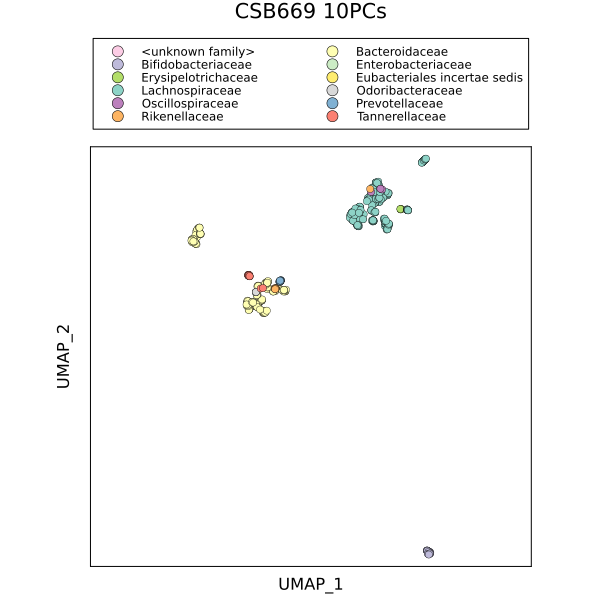

In [181]:
scatter(pcs_coords[:, 1], pcs_coords[:, 2],
    group=familyid,
    alpha=1, markerstrokewidth=.3,
    size=(600,600),
    legend=:outertop,
    legendcolumns=2,
    c=familycolors,
    ticks=:none,
    title="CSB669 10PCs",
    xlabel="UMAP_1",
    ylabel="UMAP_2",
)

In [182]:
savefig(joinpath(pdir, "umap_top10PCs_669isolates_byfamily.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/UMAPof669isolates_latentspace/umap_top10PCs_669isolates_byfamily.pdf"

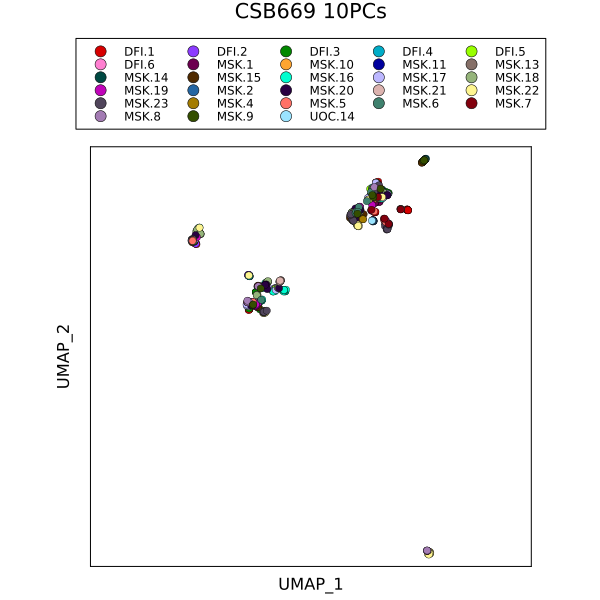

In [184]:
scatter(pcs_coords[:, 1], pcs_coords[:, 2],
    group=donorid,
    alpha=1, markerstrokewidth=.3,
    size=(600,600),
    legend=:outertop,
    legendcolumns=5,
    c=permutedims(getindex.(Ref(donorcolorsdict), sort(unique(donorid)))),
    ticks=:none,
    title="CSB669 10PCs",
    xlabel="UMAP_1",
    ylabel="UMAP_2",
)

In [42]:
savefig(joinpath(pdir, "umap_top10PCs_669isolates_bydonor.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/UMAPof669isolates_latentspace/umap_top10PCs_669isolates_bydonor.pdf"

In [43]:
getlims(x) = extrema(x) |> x->abs.(x) |> maximum |> x->(-x, x)

getlims (generic function with 1 method)

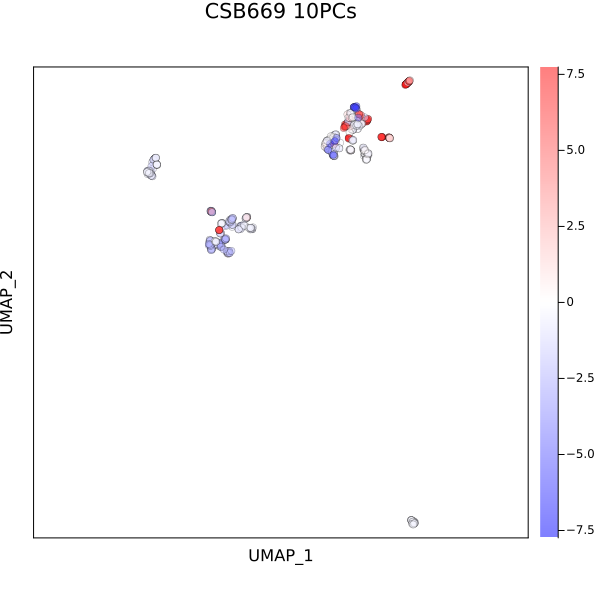

In [44]:
scatter(pcs_coords[:, 1], pcs_coords[:, 2],
    marker_z=butyrate, c=:bwr, clims=getlims(butyrate),
    alpha=.5, markerstrokewidth=.3,
    size=(600,600),
    # legend=:outertop,
    # legendcolumns=5,
    # c=permutedims(palette(:glasbey_bw_n256).colors.colors),
    ticks=:none,
    title="CSB669 10PCs",
    xlabel="UMAP_1",
    ylabel="UMAP_2",
)

In [45]:
savefig(joinpath(pdir, "umap_top10PCs_669isolates_butyrate.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/UMAPof669isolates_latentspace/umap_top10PCs_669isolates_butyrate.pdf"

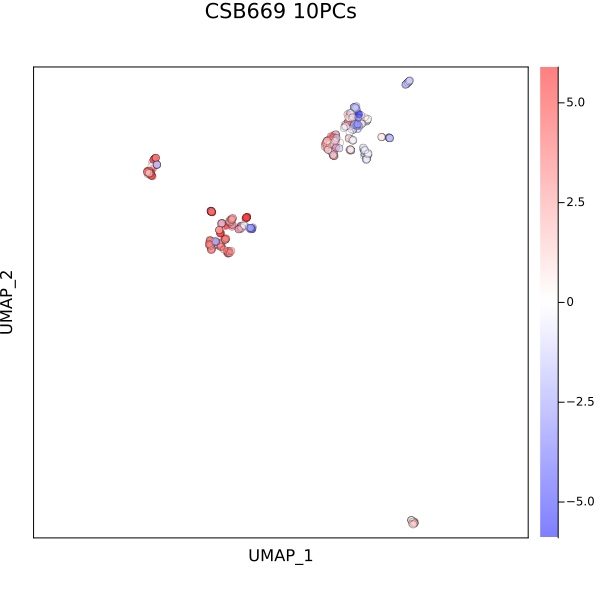

In [46]:
scatter(pcs_coords[:, 1], pcs_coords[:, 2],
    marker_z=succinate, c=:bwr, clims=getlims(succinate),
    alpha=.5, markerstrokewidth=.3,
    size=(600,600),
    # legend=:outertop,
    # legendcolumns=5,
    # c=permutedims(palette(:glasbey_bw_n256).colors.colors),
    ticks=:none,
    title="CSB669 10PCs",
    xlabel="UMAP_1",
    ylabel="UMAP_2",
)

In [47]:
savefig(joinpath(pdir, "umap_top10PCs_669isolates_succinate.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/UMAPof669isolates_latentspace/umap_top10PCs_669isolates_succinate.pdf"

In [ ]:
species_labelscounts = map(specieslabels[Not(9)]) do label
    cnt = occursin.(biobank.obs.species, label) |> sum
    label, cnt
end |> x->sort(x, by=last, rev=true)

In [ ]:
ps = []
for (label, cnt) in species_labelscounts
    mask = occursin.(biobank.obs.species, label)
    p = plot()
    scatter!(pcs_coords[.!mask, 1], pcs_coords[.!mask, 2]; c=:lightgrey, alpha=.1, markersize=2, markerstrokewidth=0)
    scatter!(pcs_coords[mask, 1], pcs_coords[mask, 2];
        title="$label ($cnt)", 
        c=:aqua,
        alpha=1, 
        markersize=3, 
        markerstrokewidth=0, 
    )
    push!(ps, p)
end
plot(ps...;
    layout=grid(3,3),
    size=(700,700),
    supertitle="CSB669 10PCs",
    xlabel="UMAP_1",
    ylabel="UMAP_2",
    titlefontsize=8,
    labelfontsize=6,
    ticks=false,
    margin=5Plots.mm,

)

## PC plots

In [13]:
pctvar = SPI.explainedvariance(bbusv_csb.S) .* 100;

In [14]:
# pcs_coords = umap(pcs_csb[:, 1:10]', 2; n_neighbors=355, metric=Euclidean())';
pcs_csb = bbusv_csb.U * diagm(bbusv_csb.S);

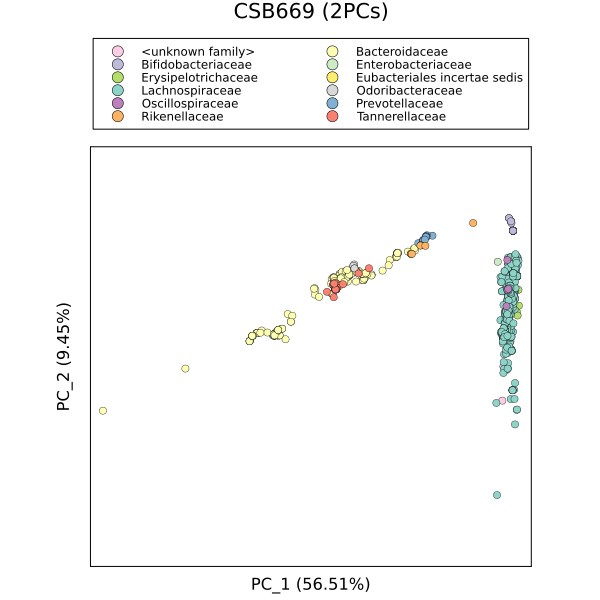

In [21]:
scatter(pcs_csb[:, 1], pcs_csb[:, 2],
    group=familyid,
    alpha=1, markerstrokewidth=.3,
    size=(600,600),
    legend=:outertop,
    legendcolumns=2,
    c=familycolors,
    ticks=:none,
    title="CSB669 (2PCs)",
    xlabel="PC_1 ($(round(pctvar[1], digits=2))%)",
    ylabel="PC_2 ($(round(pctvar[2], digits=2))%)",
)

In [51]:
savefig(joinpath(pdir, "PCplot_PCs1and2_669isolates_byfamily.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/UMAPof669isolates_latentspace/PCplot_PCs1and2_669isolates_byfamily.pdf"

In [26]:
species_labelscounts = map(specieslabels[Not(9)]) do label
    cnt = occursin.(biobank.obs.species, label) |> sum
    label, cnt
end |> x->sort(x, by=last, rev=true)

9-element Vector{Tuple{String, Int64}}:
 ("Phocaeicola vulgatus", 88)
 ("[Ruminococcus] gnavus", 41)
 ("Bacteroides thetaiotaomicron", 35)
 ("Anaerostipes hadrus", 31)
 ("Bacteroides uniformis", 27)
 ("Bifidobacterium breve", 24)
 ("Coprococcus comes", 23)
 ("Dorea formicigenerans", 22)
 ("[Eubacterium] rectale", 20)

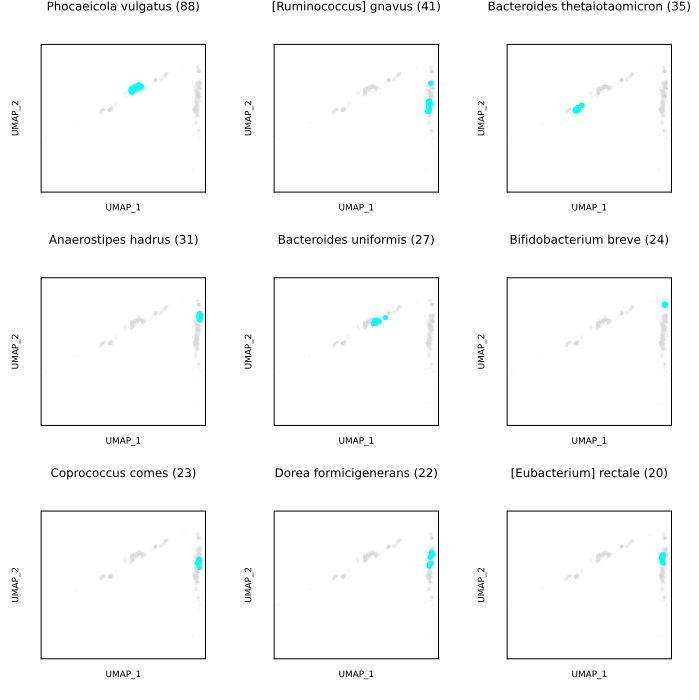

In [30]:
ps = []
for (label, cnt) in species_labelscounts
    mask = occursin.(biobank.obs.species, label)
    p = plot()
    scatter!(pcs_csb[.!mask, 1], pcs_csb[.!mask, 2]; c=:lightgrey, alpha=.1, markersize=2, markerstrokewidth=0)
    scatter!(pcs_csb[mask, 1], pcs_csb[mask, 2];
        title="$label ($cnt)", 
        c=:aqua,
        alpha=1, 
        markersize=3, 
        markerstrokewidth=0, 
    )
    push!(ps, p)
end
plot(ps...;
    layout=grid(3,3),
    size=(700,700),
    supertitle="CSB669 10PCs",
    xlabel="UMAP_1",
    ylabel="UMAP_2",
    titlefontsize=8,
    labelfontsize=6,
    ticks=false,
    margin=5Plots.mm,

)

In [31]:
savefig(joinpath(pdir, "PCplot_PCs1and2_669isolates_split_by_largest_species.pdf"))

"/Users/bend/projects/Doran_etal_2022/plots/UMAPof669isolates_latentspace/PCplot_PCs1and2_669isolates_split_by_largest_species.pdf"

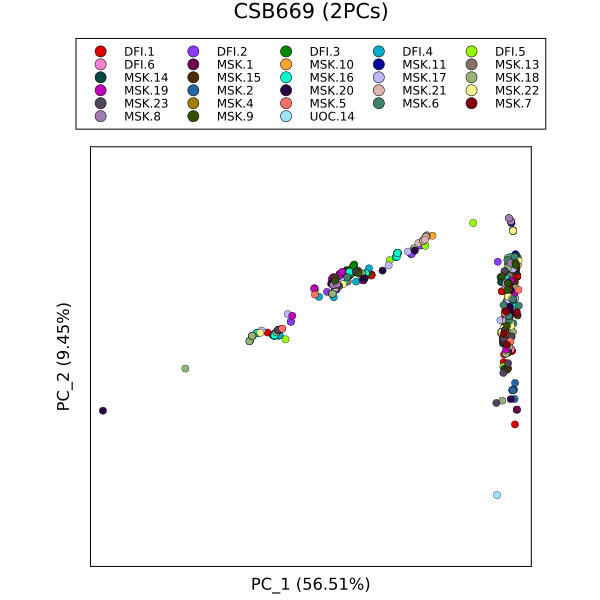

In [185]:
scatter(pcs_csb[:, 1], pcs_csb[:, 2],
    group=donorid,
    alpha=1, markerstrokewidth=.3,
    size=(600,600),
    legend=:outertop,
    legendcolumns=5,
    c=permutedims(getindex.(Ref(donorcolorsdict), sort(unique(donorid)))),
    ticks=:none,
    title="CSB669 (2PCs)",
    xlabel="PC_1 ($(round(pctvar[1], digits=2))%)",
    ylabel="PC_2 ($(round(pctvar[2], digits=2))%)",
)

In [53]:
savefig(joinpath(pdir, "PCplot_PCs1and2_669isolates_bydonor.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/UMAPof669isolates_latentspace/PCplot_PCs1and2_669isolates_bydonor.pdf"

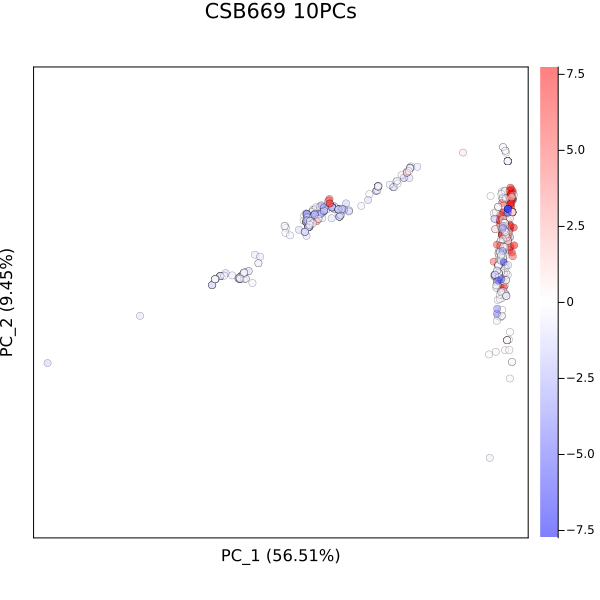

In [54]:
scatter(pcs_csb[:, 1], pcs_csb[:, 2],
    marker_z=butyrate, c=:bwr, clims=getlims(butyrate),
    alpha=.5, markerstrokewidth=.3,
    size=(600,600),
    # legend=:outertop,
    # legendcolumns=5,
    # c=permutedims(palette(:glasbey_bw_n256).colors.colors),
    ticks=:none,
    title="CSB669 10PCs",
    xlabel="PC_1 ($(round(pctvar[1], digits=2))%)",
    ylabel="PC_2 ($(round(pctvar[2], digits=2))%)",
)

In [55]:
savefig(joinpath(pdir, "PCplot_PCs1and2_669isolates_butyrate.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/UMAPof669isolates_latentspace/PCplot_PCs1and2_669isolates_butyrate.pdf"

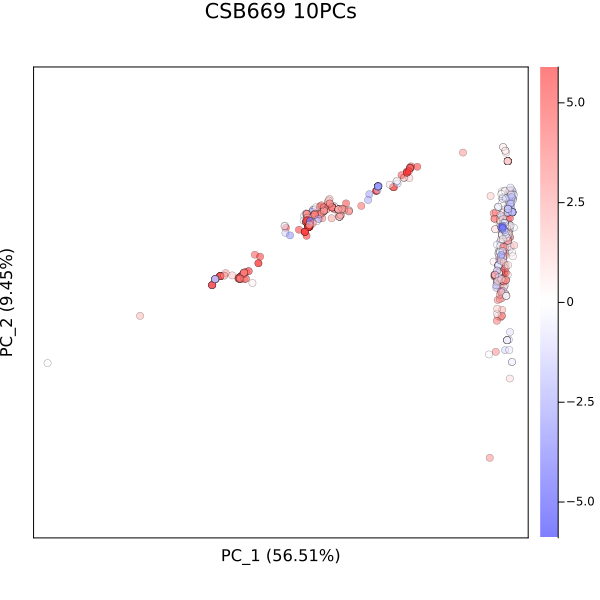

In [56]:
scatter(pcs_csb[:, 1], pcs_csb[:, 2],
    marker_z=succinate, c=:bwr, clims=getlims(succinate),
    alpha=.5, markerstrokewidth=.3,
    size=(600,600),
    # legend=:outertop,
    # legendcolumns=5,
    # c=permutedims(palette(:glasbey_bw_n256).colors.colors),
    ticks=:none,
    title="CSB669 10PCs",
    xlabel="PC_1 ($(round(pctvar[1], digits=2))%)",
    ylabel="PC_2 ($(round(pctvar[2], digits=2))%)",
)

In [57]:
savefig(joinpath(pdir, "PCplot_PCs1and2_669isolates_succinate.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/UMAPof669isolates_latentspace/PCplot_PCs1and2_669isolates_succinate.pdf"

## Bacteroidaceae

In [186]:
bmask = biobank.obs.family .== "Bacteroidaceae";

In [187]:
csb_mtx = biobank["oggs"].X[:,:][bmask, :]
# bbusv_csb = svd(csb_mtx);
ogg_mask = vec(var(csb_mtx, dims=1) .> 0)
zcsb_mtx = mapslices(x->x.-mean(x), csb_mtx[:, ogg_mask], dims=1)
bbusv_csb = svd(zcsb_mtx);

In [188]:
size(zcsb_mtx)

(229, 3755)

In [189]:
pctvar = SPI.explainedvariance(bbusv_csb.S) .* 100;

In [190]:
sum(pctvar[1:2])

62.171577143516814

In [191]:
sum(pctvar[1:10])

87.56377453426506

In [193]:
genusid = biobank.obs.genus_ncbi[bmask];

In [194]:
gr()

Plots.GRBackend()

In [195]:
pctvar = SPI.explainedvariance(bbusv_csb.S) .* 100;

In [196]:
# pcs_coords = umap(pcs_csb[:, 1:10]', 2; n_neighbors=355, metric=Euclidean())';
pcs_csb = bbusv_csb.U * diagm(bbusv_csb.S);

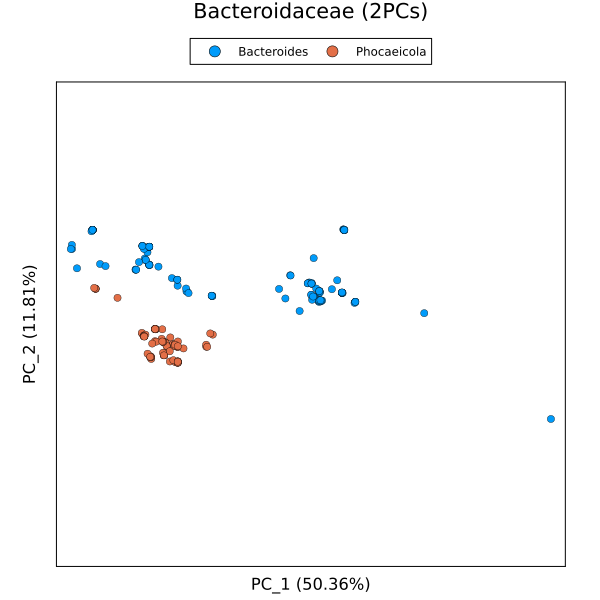

In [197]:
scatter(pcs_csb[:, 1], pcs_csb[:, 2],
    group=genusid,
    alpha=1, markerstrokewidth=.3,
    size=(600,600),
    legend=:outertop,
    legendcolumns=2,
    # c=familycolors,
    ticks=:none,
    title="Bacteroidaceae (2PCs)",
    xlabel="PC_1 ($(round(pctvar[1], digits=2))%)",
    ylabel="PC_2 ($(round(pctvar[2], digits=2))%)",
)

In [198]:
savefig(joinpath(pdir, "PCplot_PCs1and2_Bacteroidaceae_bygenus.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/UMAPof669isolates_latentspace/PCplot_PCs1and2_Bacteroidaceae_bygenus.pdf"

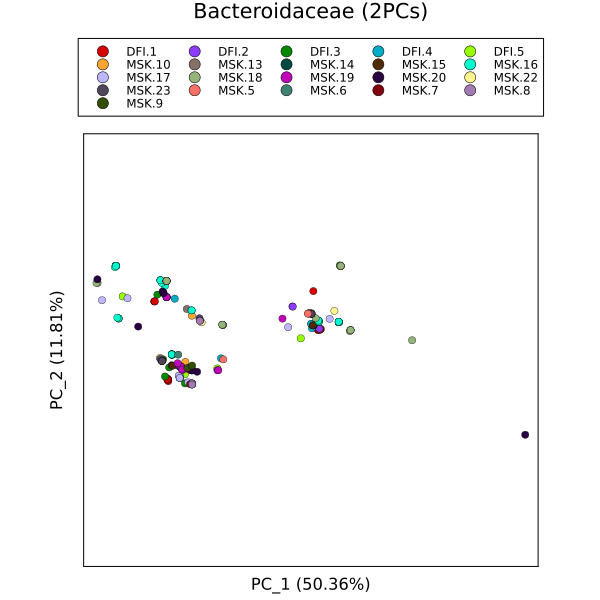

In [199]:
scatter(pcs_csb[:, 1], pcs_csb[:, 2],
    group=donorid[bmask],
    alpha=1, markerstrokewidth=.3,
    size=(600,600),
    legend=:outertop,
    legendcolumns=5,
    c=permutedims(getindex.(Ref(donorcolorsdict), sort(unique(donorid[bmask])))),
    ticks=:none,
    title="Bacteroidaceae (2PCs)",
    xlabel="PC_1 ($(round(pctvar[1], digits=2))%)",
    ylabel="PC_2 ($(round(pctvar[2], digits=2))%)",
)

In [118]:
savefig(joinpath(pdir, "PCplot_PCs1and2_Bacteroidaceae_bydonor.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/UMAPof669isolates_latentspace/PCplot_PCs1and2_Bacteroidaceae_bydonor.pdf"

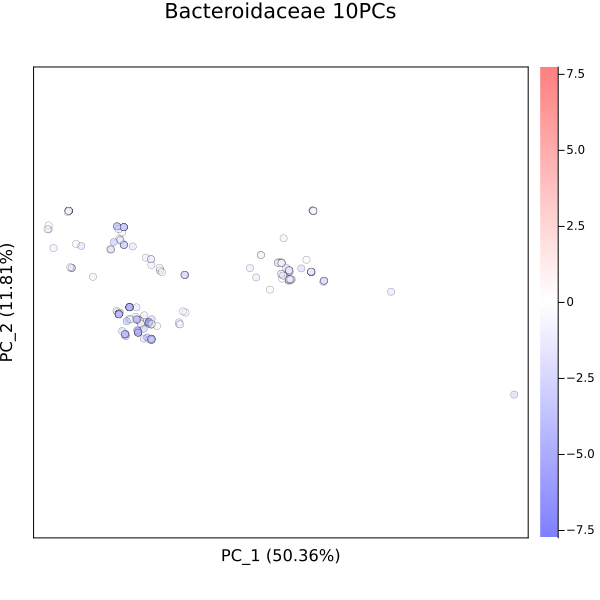

In [119]:
scatter(pcs_csb[:, 1], pcs_csb[:, 2],
    marker_z=butyrate[bmask], c=:bwr, clims=getlims(butyrate),
    alpha=.5, markerstrokewidth=.3,
    size=(600,600),
    # legend=:outertop,
    # legendcolumns=5,
    # c=permutedims(palette(:glasbey_bw_n256).colors.colors),
    ticks=:none,
    title="Bacteroidaceae 10PCs",
    xlabel="PC_1 ($(round(pctvar[1], digits=2))%)",
    ylabel="PC_2 ($(round(pctvar[2], digits=2))%)",
)

In [120]:
savefig(joinpath(pdir, "PCplot_PCs1and2_Bacteroidaceae_butyrate.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/UMAPof669isolates_latentspace/PCplot_PCs1and2_Bacteroidaceae_butyrate.pdf"

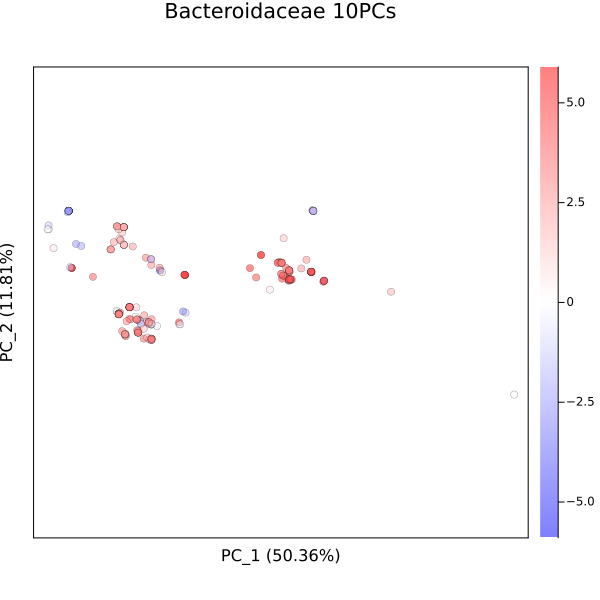

In [121]:
scatter(pcs_csb[:, 1], pcs_csb[:, 2],
    marker_z=succinate[bmask], c=:bwr, clims=getlims(succinate),
    alpha=.5, markerstrokewidth=.3,
    size=(600,600),
    # legend=:outertop,
    # legendcolumns=5,
    # c=permutedims(palette(:glasbey_bw_n256).colors.colors),
    ticks=:none,
    title="Bacteroidaceae 10PCs",
    xlabel="PC_1 ($(round(pctvar[1], digits=2))%)",
    ylabel="PC_2 ($(round(pctvar[2], digits=2))%)",
)

In [122]:
savefig(joinpath(pdir, "PCplot_PCs1and2_Bacteroidaceae_succinate.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/UMAPof669isolates_latentspace/PCplot_PCs1and2_Bacteroidaceae_succinate.pdf"

## Phocaeicoli

In [258]:
pmask = biobank.obs.genus_ncbi .== "Phocaeicola";

In [259]:
csb_mtx = biobank["oggs"].X[:,:][pmask, :]
# bbusv_csb = svd(csb_mtx);
ogg_mask = vec(var(csb_mtx, dims=1) .> 0)
zcsb_mtx = mapslices(x->x.-mean(x), csb_mtx[:, ogg_mask], dims=1)
bbusv_csb = svd(zcsb_mtx);

In [260]:
size(zcsb_mtx)

(103, 2065)

In [261]:
pctvar = SPI.explainedvariance(bbusv_csb.S) .* 100;

In [262]:
sum(pctvar[1:2])

42.29554179880617

In [263]:
sum(pctvar[1:10])

89.69865284271313

In [265]:
# pcs_coords = umap(pcs_csb[:, 1:10]', 2; n_neighbors=355, metric=Euclidean())';
pcs_csb = bbusv_csb.U * diagm(bbusv_csb.S);

In [266]:
speciesid = biobank.obs.species_ncbi[pmask];

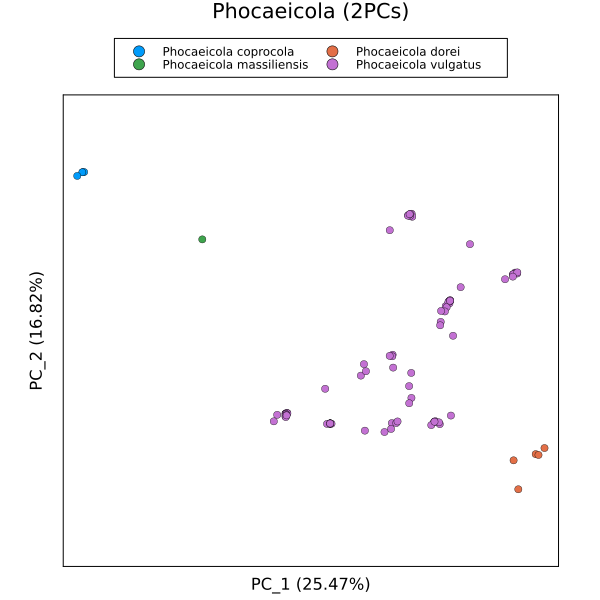

In [267]:
scatter(pcs_csb[:, 1], pcs_csb[:, 2],
    group=speciesid,
    alpha=1, markerstrokewidth=.3,
    size=(600,600),
    legend=:outertop,
    legendcolumns=2,
    # c=familycolors,
    ticks=:none,
    title="Phocaeicola (2PCs)",
    xlabel="PC_1 ($(round(pctvar[1], digits=2))%)",
    ylabel="PC_2 ($(round(pctvar[2], digits=2))%)",
)

In [268]:
savefig(joinpath(pdir, "PCplot_PCs1and2_Phocaeicola_byspecies.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/UMAPof669isolates_latentspace/PCplot_PCs1and2_Phocaeicola_byspecies.pdf"

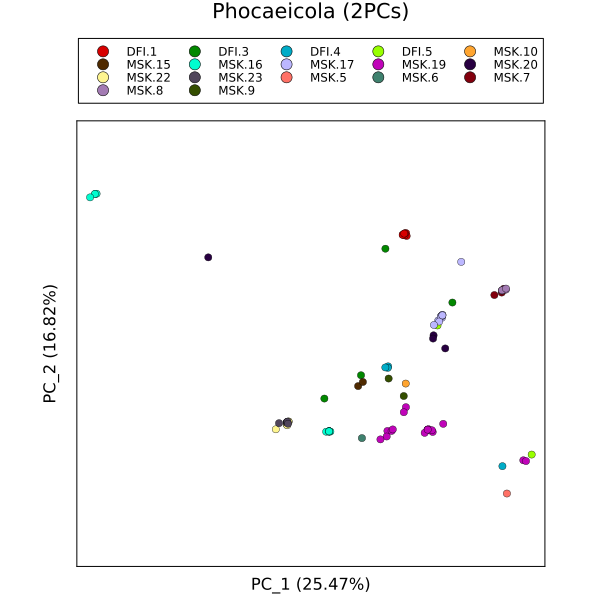

In [271]:
scatter(pcs_csb[:, 1], pcs_csb[:, 2],
    group=donorid[pmask],
    alpha=1, markerstrokewidth=.3,
    size=(600,600),
    legend=:outertop,
    legendcolumns=5,
    c=permutedims(getindex.(Ref(donorcolorsdict), sort(unique(donorid[pmask])))),
    ticks=:none,
    title="Phocaeicola (2PCs)",
    xlabel="PC_1 ($(round(pctvar[1], digits=2))%)",
    ylabel="PC_2 ($(round(pctvar[2], digits=2))%)",
)

In [272]:
savefig(joinpath(pdir, "PCplot_PCs1and2_Phocaeicola_bydonor.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/UMAPof669isolates_latentspace/PCplot_PCs1and2_Phocaeicola_bydonor.pdf"

In [276]:
all(isfinite, butyrate[pmask])

true

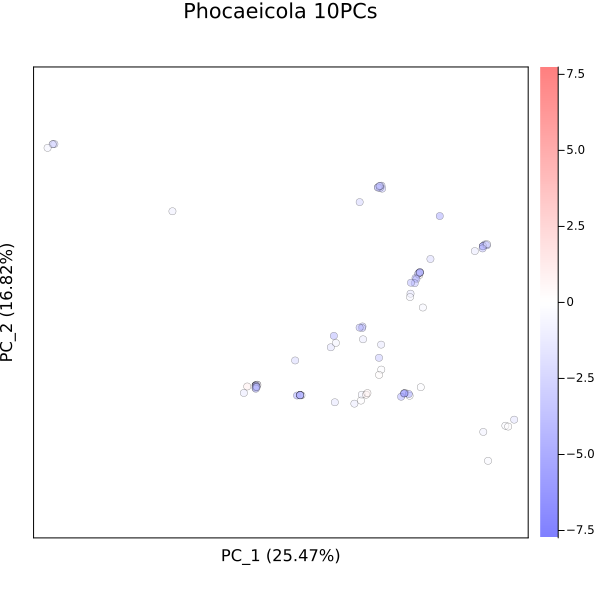

In [273]:
scatter(pcs_csb[:, 1], pcs_csb[:, 2],
    marker_z=butyrate[pmask], c=:bwr, clims=getlims(butyrate),
    alpha=.5, markerstrokewidth=.3,
    size=(600,600),
    ticks=:none,
    title="Phocaeicola 10PCs",
    xlabel="PC_1 ($(round(pctvar[1], digits=2))%)",
    ylabel="PC_2 ($(round(pctvar[2], digits=2))%)",
)

In [277]:
savefig(joinpath(pdir, "PCplot_PCs1and2_Phocaeicola_butyrate.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/UMAPof669isolates_latentspace/PCplot_PCs1and2_Phocaeicola_butyrate.pdf"

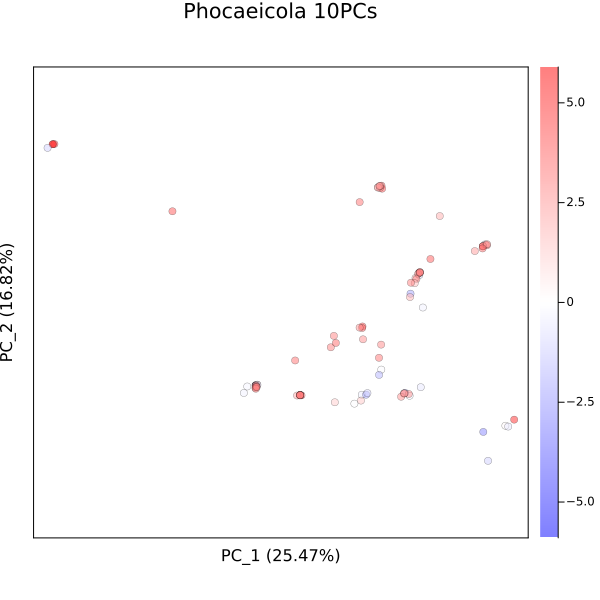

In [279]:
scatter(pcs_csb[:, 1], pcs_csb[:, 2],
    marker_z=succinate[pmask], c=:bwr, clims=getlims(succinate),
    alpha=.5, markerstrokewidth=.3,
    size=(600,600),
    ticks=:none,
    title="Phocaeicola 10PCs",
    xlabel="PC_1 ($(round(pctvar[1], digits=2))%)",
    ylabel="PC_2 ($(round(pctvar[2], digits=2))%)",
)

In [280]:
savefig(joinpath(pdir, "PCplot_PCs1and2_Phocaeicola_succinate.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/UMAPof669isolates_latentspace/PCplot_PCs1and2_Phocaeicola_succinate.pdf"

## Vulgatus

In [281]:
vmask = biobank.obs.species_ncbi .== "Phocaeicola vulgatus";

In [282]:
csb_mtx = biobank["oggs"].X[:,:][vmask, :]
# bbusv_csb = svd(csb_mtx);
ogg_mask = vec(var(csb_mtx, dims=1) .> 0)
zcsb_mtx = mapslices(x->x.-mean(x), csb_mtx[:, ogg_mask], dims=1)
bbusv_csb = svd(zcsb_mtx);

In [283]:
size(zcsb_mtx)

(93, 1551)

In [284]:
pctvar = SPI.explainedvariance(bbusv_csb.S) .* 100;

In [285]:
sum(pctvar[1:2])

44.866127359738314

In [286]:
sum(pctvar[1:10])

92.40639403321643

In [288]:
# pcs_coords = umap(pcs_csb[:, 1:10]', 2; n_neighbors=355, metric=Euclidean())';
pcs_csb = bbusv_csb.U * diagm(bbusv_csb.S);

In [289]:
speciesid = biobank.obs.species_ncbi[vmask];

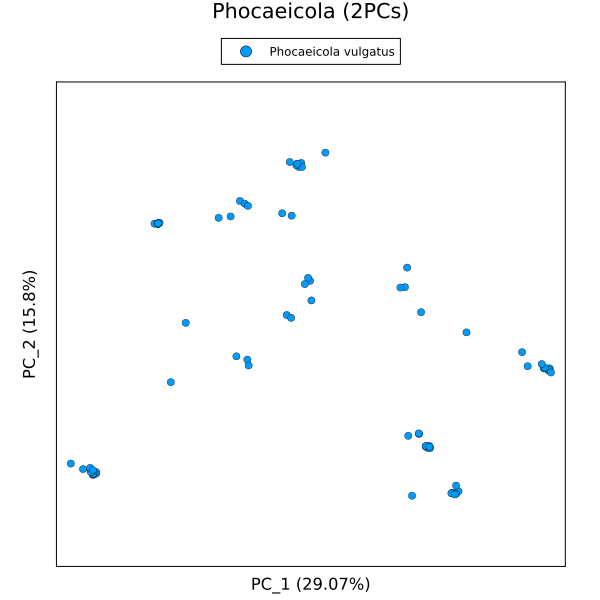

In [290]:
scatter(pcs_csb[:, 1], pcs_csb[:, 2],
    group=speciesid,
    alpha=1, markerstrokewidth=.3,
    size=(600,600),
    legend=:outertop,
    # legendcolumns=2,
    # c=familycolors,
    ticks=:none,
    title="P. vulgatus (2PCs)",
    xlabel="PC_1 ($(round(pctvar[1], digits=2))%)",
    ylabel="PC_2 ($(round(pctvar[2], digits=2))%)",
)

In [291]:
savefig(joinpath(pdir, "PCplot_PCs1and2_Pvulgatus_byspecies.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/UMAPof669isolates_latentspace/PCplot_PCs1and2_Pvulgatus_byspecies.pdf"

In [292]:
gr()

Plots.GRBackend()

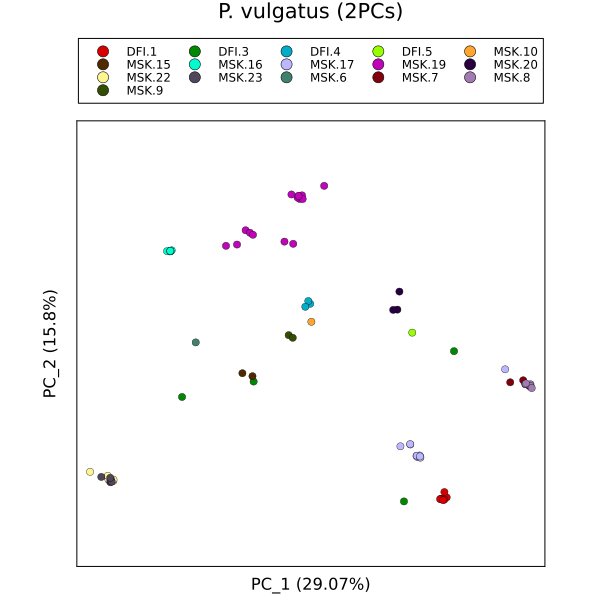

In [293]:
scatter(pcs_csb[:, 1], pcs_csb[:, 2],
    group=donorid[vmask],
    alpha=1, markerstrokewidth=.3,
    size=(600,600),
    legend=:outertop,
    legendcolumns=5,
    hovor=donorid[vmask],
    c=permutedims(getindex.(Ref(donorcolorsdict), sort(unique(donorid[vmask])))),
    ticks=:none,
    title="P. vulgatus (2PCs)",
    xlabel="PC_1 ($(round(pctvar[1], digits=2))%)",
    ylabel="PC_2 ($(round(pctvar[2], digits=2))%)",
)

In [294]:
savefig(joinpath(pdir, "PCplot_PCs1and2_Pvulgatus_bydonor.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/UMAPof669isolates_latentspace/PCplot_PCs1and2_Pvulgatus_bydonor.pdf"

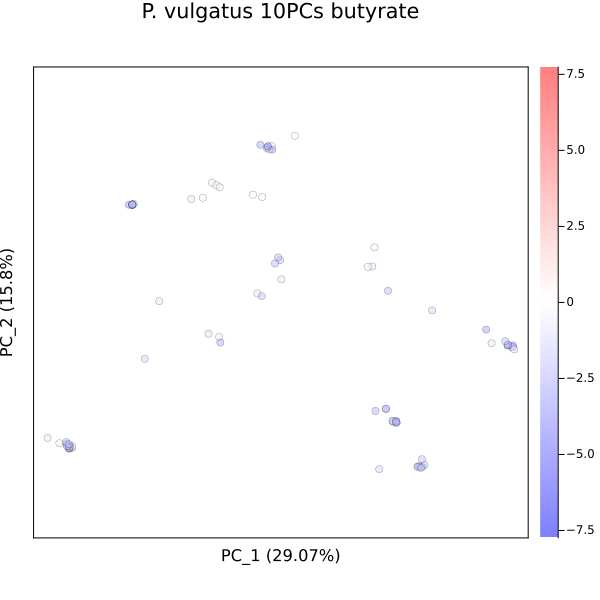

In [301]:
scatter(pcs_csb[:, 1], pcs_csb[:, 2],
    marker_z=butyrate[vmask], c=:bwr, clims=getlims(butyrate),
    alpha=.5, markerstrokewidth=.3,
    size=(600,600),
    ticks=:none,
    title="P. vulgatus 10PCs butyrate",
    xlabel="PC_1 ($(round(pctvar[1], digits=2))%)",
    ylabel="PC_2 ($(round(pctvar[2], digits=2))%)",
)

In [302]:
savefig(joinpath(pdir, "PCplot_PCs1and2_Pvulgatus_butyrate.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/UMAPof669isolates_latentspace/PCplot_PCs1and2_Pvulgatus_butyrate.pdf"

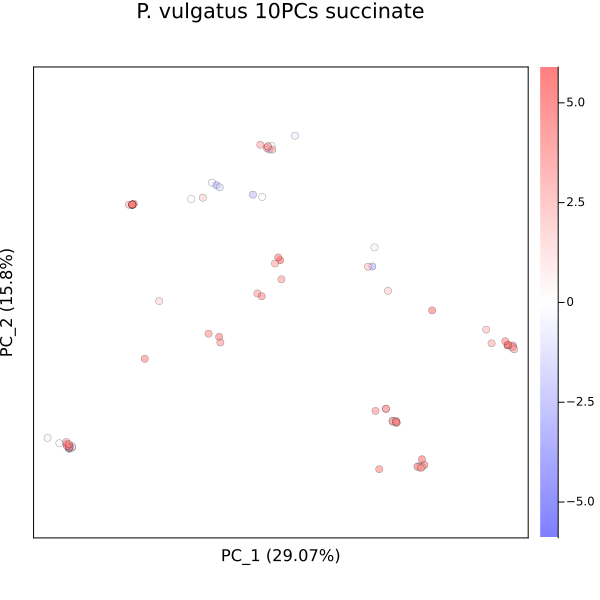

In [304]:
scatter(pcs_csb[:, 1], pcs_csb[:, 2],
    marker_z=succinate[vmask], c=:bwr, clims=getlims(succinate),
    alpha=.5, markerstrokewidth=.3,
    size=(600,600),
    ticks=:none,
    title="P. vulgatus 10PCs succinate",
    xlabel="PC_1 ($(round(pctvar[1], digits=2))%)",
    ylabel="PC_2 ($(round(pctvar[2], digits=2))%)",
)

In [305]:
savefig(joinpath(pdir, "PCplot_PCs1and2_Pvulgatus_succinate.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/UMAPof669isolates_latentspace/PCplot_PCs1and2_Pvulgatus_succinate.pdf"